## Import files for analysis

Using counts of reads mapped to protein coding genes from the Psa-V genome and plasmid. Files generated by 
kallisto.

In [1]:
library(tximport)
library(readr)
library(DESeq2)
library(ggplot2)
library(ggrepel)

#read in samples in kallisto tsv format using tximport
samples <- read.table("mapping/sample_paths_all.txt",
    header = FALSE,stringsAsFactors = FALSE)
files <- file.path(samples$V1)
names(files) <- levels(samples$V1)
##tx2gene is a file of gene names required by kallisto for naming transcripts
tx2gene <- read.csv("DESeq_analysis/fake_tx2gene.csv")
txi.kallisto.tsv <- tximport(
    files,
    type = "kallisto",
    tx2gene=tx2gene)

#make table of countfiles for all experiments
sampleTable <-read.csv(
    file.path(
        "mapping/",
        "sample_growth_conditions_all.csv"),
    header = TRUE)

#make table of experimental design
rownames(sampleTable) <- colnames(txi.kallisto.tsv$counts)


Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

In [2]:
print(sampleTable)

      sample timepoint      type
1         16    1.5hrs in_planta
2         17    1.5hrs in_planta
3         20    1.5hrs in_planta
4         25      3hrs in_planta
5         26      3hrs in_planta
6         27      3hrs in_planta
7         28      6hrs in_planta
8         29      6hrs in_planta
9         30      6hrs in_planta
10        34     12hrs in_planta
11        37     12hrs in_planta
12        38     12hrs in_planta
13         3     24hrs in_planta
14        41     24hrs in_planta
15        42     24hrs in_planta
16        10     48hrs in_planta
17        43     48hrs in_planta
18        44     48hrs in_planta
19        12     72hrs in_planta
20         6     72hrs in_planta
21         8     72hrs in_planta
22        55     96hrs in_planta
23        56     96hrs in_planta
24        57     96hrs in_planta
25        49    120hrs in_planta
26        50    120hrs in_planta
27        51    120hrs in_planta
28 Sample_01   minimal  in_vitro
29 Sample_02   minimal  in_vitro
30 Sample_

In [3]:
#run DESeq2 using this experiment design and log normalise counts
ddsTxi <- DESeqDataSetFromTximport(
    txi.kallisto.tsv, 
    colData = sampleTable,
    design= ~ timepoint)
#filter rows with no counts
ddsTxi <- ddsTxi[rowSums(counts(ddsTxi)) > 1,] 
ddsTxi <- DESeq(ddsTxi)
summary(ddsTxi)
rld <- rlog(ddsTxi)



using counts and average transcript lengths from tximport
estimating size factors
using 'avgTxLength' from assays(dds), correcting for library size
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


      Length        Class         Mode 
        5821 DESeqDataSet           S4 

png 
  2

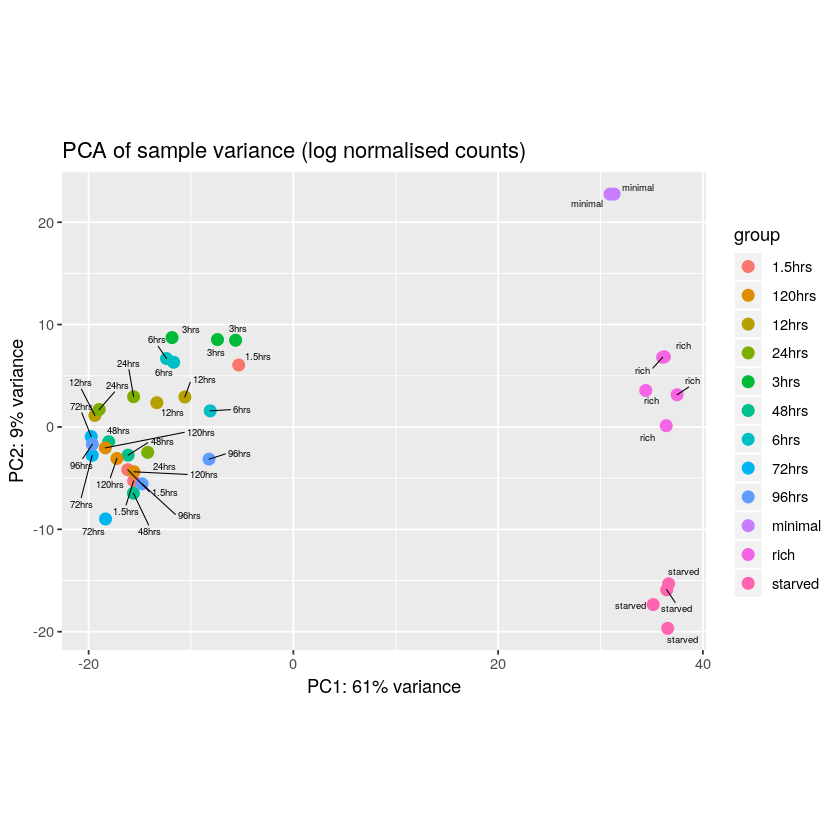

In [4]:
#generate PCA plot

p <- plotPCA(rld, intgroup="timepoint")
p <- p + 
    ggtitle(aes(label = "PCA of sample variance (log normalised counts)")) +
    geom_text_repel(aes(label = timepoint),
        size=2,
        color="black",
        force=7.5,
        segment.size=0.3)

pdf("DESeq_analysis/plots/in_planta_vs_in_vitro/PCA_all_samples.pdf")
p
dev.off()
p

In [5]:
pdf("DESeq_analysis/plots/in_planta_vs_in_vitro/MA_plot_all_samples.pdf")
plotMA(ddsTxi)
dev.off()


png 
  2

In [6]:
#what are PC1/PC2?

#modified pcaPlot function to get rotation matrix
rv <- rowVars(assay(rld))

# select the top 500 genes by variance (default for plotPCA)
select <- order(rv,
                decreasing=TRUE)[seq_len(min(500, length(rv)))]

# perform a PCA on the data in assay(x) for the selected genes
pca <- prcomp(t(assay(rld)[select,]))
tmp <- pca$rotation
write.csv(pca$rotation,
          file="DESeq_analysis/in_planta_vs_in_vitro_PCA_all.csv")
#output genes and variance used to generate PCA
write.csv(pca$center,
          file="DESeq_analysis/in_planta_vs_in_vitro_PCA_PC1.csv")
#extract data on how genes contibute to principal component variance
library(factoextra)
res.var <- get_pca_var(pca)
contrib <- res.var$contrib
write.csv(res.var$contrib,
          file="DESeq_analysis/in_planta_vs_in_vitro_PCA_contributions")

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


In [7]:
normCounts <- counts(ddsTxi,normalized=TRUE)
write.csv(normCounts,
          file="DESeq_analysis/in_planta_vs_in_vitro_normalised_counts_all.csv")

#are genes from PC1 up in planta or in vitro?
#run DESeq2 comparing in planta and in vitro and log normalise counts
ddsTxi <- DESeqDataSetFromTximport(
    txi.kallisto.tsv,
    colData = sampleTable,
    design= ~ type)

#filter rows with no counts
ddsTxi <- ddsTxi[rowSums(counts(ddsTxi)) > 1,]
ddsTxi <- DESeq(ddsTxi)
summary(ddsTxi)
rld <- rlog(ddsTxi)


res_planta_vs_vitro <- results(ddsTxi,
                               contrast = c("type",
                                            "in_planta",
                                            "in_vitro"))

write.csv(res_planta_vs_vitro,
          file="DESeq_analysis/in_planta_vs_in_vitro.csv")

using counts and average transcript lengths from tximport
estimating size factors
using 'avgTxLength' from assays(dds), correcting for library size
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 40 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


      Length        Class         Mode 
        5821 DESeqDataSet           S4 

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.


[1] 124.3068 116.5464 114.6978 117.8237 121.3446 117.7893

png 
  2

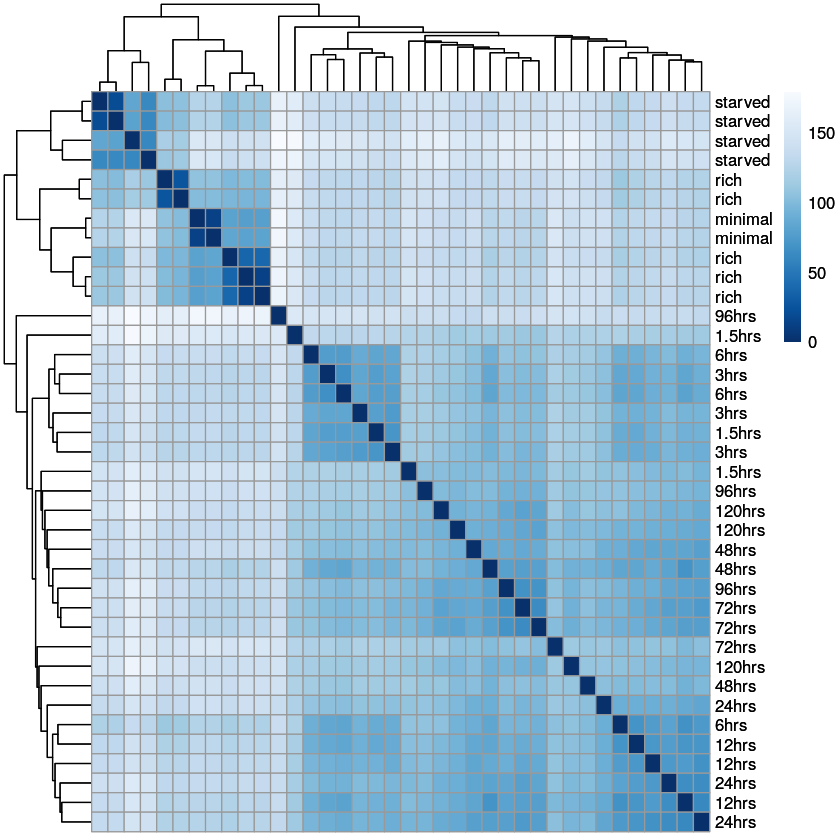

In [8]:
vsd <- vst(ddsTxi,
           blind=FALSE)
sampleDists <- dist(t(assay(vsd)))
head(sampleDists)
library("RColorBrewer")
library("pheatmap")
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$timepoint)
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette(
    rev(
        brewer.pal(
            9,
            "Blues")) )(255)
p <- pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         legend=TRUE,
         col=colors)
pdf("DESeq_analysis/plots/in_planta_vs_in_vitro/distance_heatmap_all_samples.pdf")
p
dev.off()
p

png 
  2

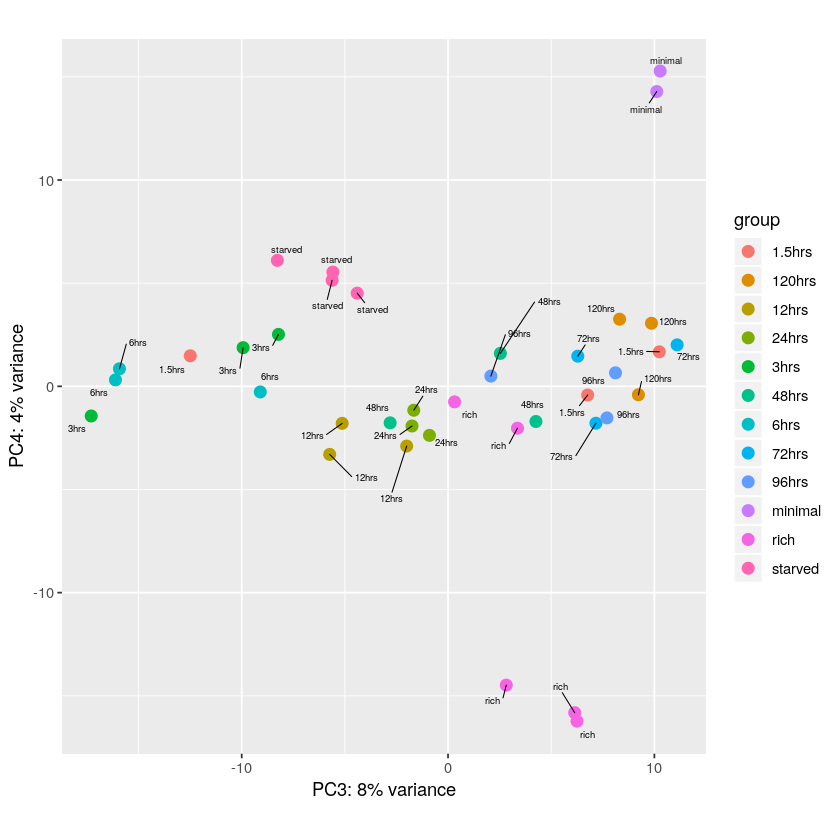

In [9]:
#modified plotPCA function to plot PC3 and PC4

plotPCA <- function (object,
                     intgroup = "condition",
                     ntop = 500, 
                     returnData = FALSE) 
{
    rv <- rowVars(assay(object))
    select <- order(rv,
                    decreasing = TRUE)[seq_len(min(ntop, 
        length(rv)))]
    pca <- prcomp(t(assay(object)[select, ]))
    percentVar <- pca$sdev^2/sum(pca$sdev^2)
    if (!all(intgroup %in% names(colData(object)))) {
        stop("the argument 'intgroup' should specify columns of colData(dds)")
    }
    intgroup.df <- as.data.frame(colData(object)[, intgroup, 
        drop = FALSE])
    group <- if (length(intgroup) > 1) {
        factor(apply(intgroup.df, 1, paste, collapse = " : "))
    }
    else {
        colData(object)[[intgroup]]
    }
    d <- data.frame(PC1 = pca$x[, 1], 
                    PC2 = pca$x[, 2],
                    PC3 = pca$x[, 3],
                    PC4 = pca$x[, 4], group = group, 
        intgroup.df, name = colnames(object))
    if (returnData) {
        attr(d, "percentVar") <- percentVar[1:2]
        return(d)
    }
    ggplot(data = d, aes_string(x = "PC3", y = "PC4", color = "group")) + 
        geom_point(size = 3) +
        xlab(paste0("PC3: ", 
                    round(percentVar[3] * 100), "% variance")) +
        ylab(paste0("PC4: ", round(percentVar[4] * 100), "% variance")) +
        coord_fixed() + geom_text_repel(
            aes(
                label = timepoint),
                size=2,
                color="black",
                force=7.5,
                segment.size=0.3)
}

pdf("DESeq_analysis/plots/in_planta_vs_in_vitro/PCA3_PCA4_all_samples.pdf")
plotPCA(rld, intgroup="timepoint")
dev.off()
plotPCA(rld, intgroup="timepoint")


In [1]:
library(tximport)
library(readr)
library(DESeq2)
library(ggplot2)
library(ggrepel)

#read in samples in kallisto tsv format using tximport
samples <- read.table("mapping/sample_paths_all.txt",
    header = FALSE,stringsAsFactors = FALSE)
files <- file.path(samples$V1)
names(files) <- levels(samples$V1)
##tx2gene is a file of gene names required by kallisto for naming transcripts
tx2gene <- read.csv("DESeq_analysis/fake_tx2gene.csv")
txi.kallisto.tsv <- tximport(
    files,
    type = "kallisto",
    tx2gene=tx2gene)

#make table of countfiles for all experiments
sampleTable <-read.csv(
    file.path(
        "mapping/",
        "sample_growth_conditions_all_2.csv"),
    header = TRUE)

#make table of experimental design
rownames(sampleTable) <- colnames(txi.kallisto.tsv$counts)


Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

In [2]:
print(sampleTable)

      sample timepoint      type
1         16    1.5hrs in_planta
2         17    1.5hrs in_planta
3         20    1.5hrs in_planta
4         25      3hrs in_planta
5         26      3hrs in_planta
6         27      3hrs in_planta
7         28      6hrs in_planta
8         29      6hrs in_planta
9         30      6hrs in_planta
10        34     12hrs in_planta
11        37     12hrs in_planta
12        38     12hrs in_planta
13         3     24hrs in_planta
14        41     24hrs in_planta
15        42     24hrs in_planta
16        10     48hrs in_planta
17        43     48hrs in_planta
18        44     48hrs in_planta
19        12     72hrs in_planta
20         6     72hrs in_planta
21         8     72hrs in_planta
22        55     96hrs in_planta
23        56     96hrs in_planta
24        57     96hrs in_planta
25        49    120hrs in_planta
26        50    120hrs in_planta
27        51    120hrs in_planta
28 Sample_01   minimal   minimal
29 Sample_02   minimal   minimal
30 Sample_

In [3]:

ddsTxi <- DESeqDataSetFromTximport(txi.kallisto.tsv, colData = sampleTable, design= ~ type)
ddsTxi <- ddsTxi[rowSums(counts(ddsTxi)) > 1,] #filter rows with no counts
ddsTxi <- DESeq(ddsTxi)
summary(ddsTxi)
rld <- rlog(ddsTxi)


res_planta_vs_min <- results(ddsTxi, contrast = c("type", "in_planta","minimal"))
res_planta_vs_rich <- results(ddsTxi, contrast = c("type", "in_planta","rich"))
res_planta_vs_starved <- results(ddsTxi, contrast = c("type", "in_planta","starved"))
write.csv(res_planta_vs_min,file="in_planta_vs_min.csv")
write.csv(res_planta_vs_rich,file="in_planta_vs_rich.csv")
write.csv(res_planta_vs_starved,file="in_planta_vs_starved.csv")




using counts and average transcript lengths from tximport
estimating size factors
using 'avgTxLength' from assays(dds), correcting for library size
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


      Length        Class         Mode 
        5821 DESeqDataSet           S4 

In [4]:
res_planta_vs_starvSIG <- res_planta_vs_starved[which(res_planta_vs_starved$padj < 0.0001),]
res_planta_vs_minSIG <- res_planta_vs_min[which(res_planta_vs_min$padj < 0.0001),]
res_planta_vs_richSIG <- res_planta_vs_rich[which(res_planta_vs_rich$padj < 0.0001),]

print(c(nrow(res_planta_vs_starvSIG),nrow(res_planta_vs_minSIG),nrow(res_planta_vs_richSIG)))

[1] 2194 1237 2045
